In [ ]:
# Author: Kaylani Bochie
# github.com/kaylani2
# kaylani AT gta DOT ufrj DOT br

### K: Model: SOM
import sys
import time
import pandas as pd
import os
import math
sys.path.insert(1, '../')
import numpy as np
from numpy import mean, std
from matplotlib import pyplot as plt
from unit import remove_columns_with_one_value, remove_nan_columns, load_dataset
from unit import display_general_information, display_feature_distribution
from collections import Counter
#from imblearn.over_sampling import RandomOverSampler, RandomUnderSampler
import sklearn
from sklearn import set_config
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.metrics import f1_score, classification_report, accuracy_score
from sklearn.metrics import cohen_kappa_score, mean_squared_error
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, PredefinedSplit, RandomizedSearchCV
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, chi2, mutual_info_classif
from sklearn.utils import class_weight
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import keras.utils
from keras import metrics
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM
from keras.optimizers import RMSprop, Adam
from keras.constraints import maxnorm
import susi
from susi.SOMPlots import plot_umatrix, plot_estimation_map


###############################################################################
## Define constants
###############################################################################
pd.set_option ('display.max_rows', None)
pd.set_option ('display.max_columns', 5)
BOT_IOT_DIRECTORY = '../../../../../datasets/bot-iot/'
BOT_IOT_FEATURE_NAMES = 'UNSW_2018_IoT_Botnet_Dataset_Feature_Names.csv'
BOT_IOT_FILE_5_PERCENT_SCHEMA = 'UNSW_2018_IoT_Botnet_Full5pc_{}.csv' # 1 - 4
FIVE_PERCENT_FILES = 4
BOT_IOT_FILE_FULL_SCHEMA = 'UNSW_2018_IoT_Botnet_Dataset_{}.csv' # 1 - 74
FULL_FILES = 74
FILE_NAME = BOT_IOT_DIRECTORY + BOT_IOT_FILE_5_PERCENT_SCHEMA
FEATURES = BOT_IOT_DIRECTORY + BOT_IOT_FEATURE_NAMES
NAN_VALUES = ['?', '.']
TARGET = 'attack'
INDEX_COLUMN = 'pkSeqID'
LABELS = ['attack', 'category', 'subcategory']
STATE = 0
try:
  STATE = int (sys.argv [1])
except:
  pass
#for STATE in [1, 2, 3, 4, 5]:
np.random.seed (STATE)
print ('STATE:', STATE)


###############################################################################
## Load dataset
###############################################################################
df = load_dataset (FILE_NAME, FIVE_PERCENT_FILES, INDEX_COLUMN, NAN_VALUES)


###############################################################################
## Clean dataset
###############################################################################
###############################################################################
### Remove columns with only one value
df, log = remove_columns_with_one_value (df, verbose = False)
print (log)


###############################################################################
### Remove redundant columns, useless columns and unused targets
### K: _number columns are numerical representations of other existing columns.
### K: category and subcategory are other labels.
### K: saddr and daddr may specialize the model to a single network
redundant_columns = ['state_number', 'proto_number', 'flgs_number']
other_targets = ['category', 'subcategory']
misc_columns = ['saddr', 'daddr']
print ('Removing redundant columns:', redundant_columns)
print ('Removing useless targets:', other_targets)
print ('Removing misc columns:', misc_columns)
columns_to_remove = redundant_columns + other_targets + misc_columns
df.drop (axis = 'columns', columns = columns_to_remove, inplace = True)

###############################################################################
### Remove NaN columns (with a lot of NaN values)
df, log = remove_nan_columns (df, 1/2, verbose = False)
print (log)

###############################################################################
### Encode categorical features
print ('Encoding categorical features (ordinal encoding).')
my_encoder = OrdinalEncoder ()
df ['flgs'] = my_encoder.fit_transform (df ['flgs'].values.reshape (-1, 1))
df ['proto'] = my_encoder.fit_transform (df ['proto'].values.reshape (-1, 1))
df ['sport'] = my_encoder.fit_transform (df ['sport'].astype (str).values.reshape (-1, 1))
df ['dport'] = my_encoder.fit_transform (df ['dport'].astype (str).values.reshape (-1, 1))
df ['state'] = my_encoder.fit_transform (df ['state'].values.reshape (-1, 1))
print ('Objects:', list (df.select_dtypes ( ['object']).columns))


###############################################################################
## Quick sanity check
###############################################################################
display_general_information (df)


###############################################################################
## Split dataset into train and test sets
###############################################################################
### K: Dataset is too big? Drop.
# drop_indices = np.random.choice (df.index, int (df.shape [0] * 0.5),
#                                  replace = False)
# df = df.drop (drop_indices)
TEST_SIZE = 3/10
VALIDATION_SIZE = 1/4
print ('Splitting dataset (test/train):', TEST_SIZE)
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split (
                                               df.loc [:, df.columns != TARGET],
                                               df [TARGET],
                                               test_size = TEST_SIZE,
                                               random_state = STATE,)
print ('Splitting dataset (validation/train):', VALIDATION_SIZE)
X_train_df, X_val_df, y_train_df, y_val_df = train_test_split (
                                             X_train_df,
                                             y_train_df,
                                             test_size = VALIDATION_SIZE,
                                             random_state = STATE,)
print ('X_train_df shape:', X_train_df.shape)
print ('y_train_df shape:', y_train_df.shape)
print ('X_val_df shape:', X_val_df.shape)
print ('y_val_df shape:', y_val_df.shape)
print ('X_test_df shape:', X_test_df.shape)
print ('y_test_df shape:', y_test_df.shape)

In [13]:
###############################################################################
## Convert dataframe to a numpy array
###############################################################################
print ('\nConverting dataframe to numpy array.')
X_train = X_train_df.values
y_train = y_train_df.values
X_val = X_val_df.values
y_val = y_val_df.values
X_test = X_test_df.values
y_test = y_test_df.values
print ('X_train shape:', X_train.shape)
print ('y_train shape:', y_train.shape)
print ('X_val shape:', X_val.shape)
print ('y_val shape:', y_val.shape)
print ('X_test shape:', X_test.shape)

print ('y_test shape:', y_test.shape)


Converting dataframe to numpy array.
X_train shape: (1925973, 37)
y_train shape: (1925973,)
X_val shape: (641992, 37)
y_val shape: (641992,)
X_test shape: (1100557, 37)
y_test shape: (1100557,)


<class 'numpy.ndarray'>
[ 5  1  5 ... 14  1  8]


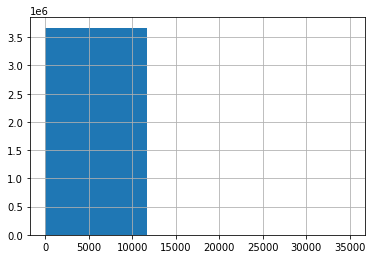

In [28]:
### PLOT
print (type (X_train))
#print (((X_train_df.dtypes)))
print (df ['spkts'].values)
hist = df ['spkts'].hist(bins=3)

In [14]:
###############################################################################
## Apply normalization
###############################################################################
### K: NOTE: Only use derived information from the train set to avoid leakage.
print ('\nApplying normalization.')
startTime = time.time ()
scaler = StandardScaler ()
#scaler = MinMaxScaler (feature_range = (0, 1))
scaler.fit (X_train)
X_train = scaler.transform (X_train)
X_val = scaler.transform (X_val)
X_test = scaler.transform (X_test)
print (str (time.time () - startTime), 'to normalize data.')


Applying normalization.
2.1253457069396973 to normalize data.


In [15]:
###############################################################################
## Perform feature selection
###############################################################################
NUMBER_OF_FEATURES = 9 #X_train.shape [-1]
print ('\nSelecting top', NUMBER_OF_FEATURES, 'features.')
fs = PCA (n_components = NUMBER_OF_FEATURES)
fs.fit (X_train)
print (fs.explained_variance_ratio_)
print (fs.singular_values_)
X_train = fs.transform (X_train)
X_val = fs.transform (X_val)
X_test = fs.transform (X_test)
print ('X_train shape:', X_train.shape)
print ('y_train shape:', y_train.shape)
print ('X_val shape:', X_val.shape)
print ('y_val shape:', y_val.shape)
print ('X_test shape:', X_test.shape)
print ('y_test shape:', y_test.shape)


Selecting top 9 features.
[0.26937754 0.14698033 0.09683159 0.05761509 0.05032776 0.04246148
 0.03897543 0.03290625 0.0313581 ]
[4381.33690129 3236.35062715 2626.84522548 2026.25496213 1893.78093644
 1739.49639999 1666.56184252 1531.31712371 1494.86107097]
X_train shape: (1925973, 9)
y_train shape: (1925973,)
X_val shape: (641992, 9)
y_val shape: (641992,)
X_test shape: (1100557, 9)
y_test shape: (1100557,)


In [18]:
som = susi.SOMClustering(
    n_rows=17,
    n_columns=17,
    verbose = 2,
    n_jobs = 4,
)
startTime = time.time ()
som.fit(X_train)
print (str (time.time () - startTime), 's to train model.')
print("SOM fitted!")

unsuper: 100%|████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 8190.50it/s]
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 151544 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done 567288 tasks      | elapsed:   20.6s
[Parallel(n_jobs=4)]: Done 1146872 tasks      | elapsed:   42.1s
[Parallel(n_jobs=4)]: Done 1894392 tasks      | elapsed:  1.2min


71.3228440284729 s to train model.
SOM fitted!


[Parallel(n_jobs=4)]: Done 1925973 out of 1925973 | elapsed:  1.2min finished


In [7]:
#print (som.score (X_test, y_test))

AttributeError: 'SOMClustering' object has no attribute 'score'

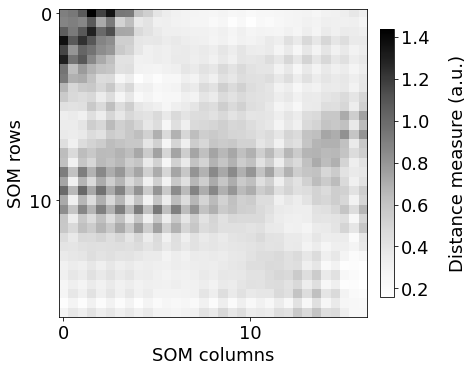

In [19]:
u_matrix = som.get_u_matrix()
plot_umatrix(u_matrix, 17, 17)
plt.show()

In [11]:
clusters = som.get_clusters(X_train)
plt.scatter(x=[c[1] for c in clusters], y=[c[0] for c in clusters], c=y, alpha=0.2)
plt.gca().invert_yaxis()
plt.show()

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
exception calling callback for <Future at 0x7f6615d1d790 state=finished raised BrokenProcessPool>
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/home/newuser/.local/share/virtualenvs/machineLearning-KVdAfBLK/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py", line 404, in _process_worker
    call_item = call_queue.get(block=True, timeout=timeout)
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 107, in get
    if not self._poll(timeout):
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 257, in poll
    return self._poll(timeout)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 424, in _poll
    r = wait([self], timeout)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 930, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.8/selectors.py", line 415, in select
 

KeyboardInterrupt: 